In [1]:
"""
EEG REST ANALYSIS - HEALTHY CONTROLS
====================================
Purpose: Establish baseline preprocessing and feature extraction pipeline
Dataset: PhysioNet EEGMMIDB - Subject 1, Run R01 (eyes open rest)
Target channels: C3, Cz, C4 (motor cortex)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# MNE imports
import mne
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.preprocessing import ICA

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)

print("="*70)
print("EEG REST ANALYSIS PIPELINE - HEALTHY BASELINE")
print("="*70)
print(f"MNE version: {mne.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print("Setup complete!\n")

EEG REST ANALYSIS PIPELINE - HEALTHY BASELINE
MNE version: 1.11.0
NumPy version: 1.26.4
Pandas version: 2.2.2
Setup complete!



In [7]:
"""
LOAD RAW EEG DATA
=================
Loading resting-state EEG (eyes open) from Subject 1, Run R01
"""

# ============================================
# CONFIGURATION
# ============================================
# Update this path to your local file location
LOCAL_FILE = "C:/Users/fibof/Downloads/NormalRest/S001R01.edf"  # Example: "C:/Users/YourName/Data/S001R01.edf"

# Alternative: Download from PhysioNet
USE_LOCAL_FILE = True  # Set to False to download from PhysioNet

print("="*70)
print("LOADING EEG DATA")
print("="*70)

# Load data
if USE_LOCAL_FILE and Path(LOCAL_FILE).exists():
    print(f"Loading from local file: {LOCAL_FILE}")
    raw = mne.io.read_raw_edf(LOCAL_FILE, preload=True, verbose=False)
    print("✓ Local file loaded successfully")
else:
    print("Downloading from PhysioNet...")
    raw_files = eegbci.load_data(subject=1, runs=[1], verbose='ERROR')
    raw = mne.io.read_raw_edf(raw_files[0], preload=True, verbose=False)
    print(f"✓ Downloaded and loaded from: {raw_files[0]}")

# ============================================
# PRINT RAW DATA STATISTICS
# ============================================
print("\n" + "-"*70)
print("RAW DATA INFORMATION")
print("-"*70)
print(f"Sampling frequency:     {raw.info['sfreq']} Hz")
print(f"Duration:               {raw.times[-1]:.2f} seconds ({raw.times[-1]/60:.2f} minutes)")
print(f"Number of channels:     {len(raw.ch_names)}")
print(f"Number of samples:      {len(raw.times)}")
print(f"Channel types:          {set(raw.get_channel_types())}")

print(f"\nFirst 10 channel names (original):")
print(f"  {raw.ch_names[:10]}")

# Check annotations
if len(raw.annotations) > 0:
    print(f"\nAnnotations present:    {len(raw.annotations)} total")
    from collections import Counter
    ann_counts = Counter(raw.annotations.description)
    print(f"Annotation types:")
    for ann_type, count in ann_counts.items():
        print(f"  {ann_type}: {count} occurrences")
else:
    print(f"\nAnnotations present:    None")

print("-"*70)

LOADING EEG DATA
Loading from local file: C:/Users/fibof/Downloads/NormalRest/S001R01.edf
✓ Local file loaded successfully

----------------------------------------------------------------------
RAW DATA INFORMATION
----------------------------------------------------------------------
Sampling frequency:     160.0 Hz
Duration:               60.99 seconds (1.02 minutes)
Number of channels:     64
Number of samples:      9760
Channel types:          {'eeg'}

First 10 channel names (original):
  ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..']

Annotations present:    1 total
Annotation types:
  T0: 1 occurrences
----------------------------------------------------------------------


In [19]:
"""
PREPROCESSING PIPELINE
======================
1. Standardize channel names
2. Set montage (standard_1005)
3. Notch filter (60 Hz power line noise)
4. Common average reference (CAR)
5. Bandpass filter (1-40 Hz for oscillatory analysis)
6. ICA artifact removal
"""

print("\n" + "="*70)
print("PREPROCESSING PIPELINE")
print("="*70)

# ============================================
# CONFIG: Preprocessing flags
# ============================================
APPLY_RESAMPLE = False      # Downsample to 256 Hz (MOVING used 256 Hz)
TARGET_SFREQ = 256         # Target sampling frequency
APPLY_ICA = True          # ICA artifact removal (set True if needed)

# ============================================
# STEP 1: Standardize channel names
# ============================================
print("\n[1/6] Standardizing channel names...")
eegbci.standardize(raw)
print(f"✓ Channel names standardized (removes dots, uses 10-20 conventions)")
print(f"  First 10 channels (standardized): {raw.ch_names[:10]}")

# ============================================
# STEP 2: Set montage
# ============================================
print("\n[2/6] Setting electrode montage...")
montage = make_standard_montage('standard_1005')
raw.set_montage(montage, on_missing='warn', verbose=False)

# Count how many channels matched
n_matched = sum([1 for ch in raw.ch_names if ch in montage.ch_names])
print(f"✓ Montage set: standard_1005")
print(f"  Channels matched to montage: {n_matched}/{len(raw.ch_names)}")
print(f"  Total positions in montage: {len(montage.ch_names)}")

# ============================================
# STEP 3: Notch filter (power line noise)
# ============================================
print("\n[3/6] Applying notch filter...")

sfreq = raw.info["sfreq"]
nyq = sfreq / 2

desired_notches = [60, 120]
notch_freqs = [f for f in desired_notches if f < nyq]

print(f"  Sampling frequency: {sfreq} Hz (Nyquist: {nyq} Hz)")
print(f"  Requested: {desired_notches}")
print(f"  Applying:  {notch_freqs} (skipping any >= Nyquist)")

if len(notch_freqs) == 0:
    print("  ⚠ No valid notch freqs. Skipping notch.")
else:
    for f in notch_freqs:
        raw.notch_filter(
            freqs=[f],
            picks="eeg",
            method="iir",
            iir_params={"order": 4, "ftype": "butter"},
            verbose=False,
        )
    print(f"✓ Notch filter applied at {notch_freqs}")

# ============================================
# STEP 4: Set common average reference (CAR)
# ============================================
print("\n[4/6] Setting reference...")
print(f"  Reference type: Common Average Reference (CAR)")
print(f"  Rationale: Reduces common noise and provides reference-free analysis")

raw.set_eeg_reference('average', projection=False, verbose=False)
print(f"✓ CAR reference applied to all EEG channels")

# ============================================
# STEP 5: Bandpass filter
# ============================================
print("\n[5/6] Applying bandpass filter...")
print(f"  Band: 1-40 Hz")
print(f"  Rationale: Captures delta, theta, alpha, beta oscillations")
print(f"  Note: This is NOT MRCP preprocessing (which needs 0.05-10 Hz)")
print(f"        We use 1-40 Hz for general oscillatory/rhythm analysis")

raw.filter(l_freq=1.0, h_freq=40.0, picks='eeg', method='iir',
          iir_params={'order': 4, 'ftype': 'butter'}, verbose=False)
print(f"✓ Bandpass filter applied: 1-40 Hz")

# ============================================
# STEP 6: Resample (optional)
# ============================================
if APPLY_RESAMPLE:
    print(f"\n[6/6] Resampling data...")
    print(f"  Original sampling frequency: {raw.info['sfreq']} Hz")
    print(f"  Target sampling frequency:   {TARGET_SFREQ} Hz")
    print(f"  Rationale: MOVING paper used 256 Hz; reduces computation")
    
    raw.resample(TARGET_SFREQ, verbose=False)
    print(f"✓ Resampled to {raw.info['sfreq']} Hz")
else:
    print(f"\n[6/6] Resampling: SKIPPED")
    print(f"  Current sampling frequency: {raw.info['sfreq']} Hz")

# ============================================
# OPTIONAL: ICA artifact removal
# ============================================
if APPLY_ICA:
    print("\n" + "-"*70)
    print("OPTIONAL: ICA ARTIFACT REMOVAL")
    print("-"*70)
    print("Fitting ICA to remove eye blinks and muscle artifacts...")
    
    # Fit ICA
    ica = ICA(n_components=20, method='fastica', random_state=42, max_iter=200)
    ica.fit(raw, picks='eeg', verbose=False)
    print(f"✓ ICA fitted with {ica.n_components_} components")
    
    # Find blink/EOG-related components:
    # 1) Prefer true EOG channel if present
    # 2) Otherwise use a frontal EEG "proxy" channel (Fp1/Fp2/Fpz/AF7/AF8)
    eog_channels = [ch for ch in raw.ch_names if "EOG" in ch.upper()]

    if eog_channels:
        print(f"  Found EOG channels: {eog_channels}")
        ch_for_eog = eog_channels[0]
    else:
        eog_proxy_candidates = ["Fp1", "Fp2", "Fpz", "AF7", "AF8", "AF3", "AF4"]
        ch_for_eog = next((ch for ch in eog_proxy_candidates if ch in raw.ch_names), None)

        if ch_for_eog is not None:
            print(f"  No EOG channels found; using EEG proxy channel: {ch_for_eog}")
        else:
            print("  No EOG channels or suitable frontal proxy found; manual ICA selection recommended")
            ch_for_eog = None

    if ch_for_eog is not None:
        eog_indices, eog_scores = ica.find_bads_eog(
            raw,
            ch_name=ch_for_eog,
            threshold=3.0,
            verbose=False
        )
        ica.exclude = eog_indices
        print(f"  Components excluded (blink-related): {eog_indices}")
    else:
        # Optional manual selection:
        # ica.plot_components()
        pass

    # Apply ICA
    if ica.exclude:
        raw = ica.apply(raw.copy(), verbose=False)
        print(f"✓ ICA applied, {len(ica.exclude)} components removed")
    else:
        print("  No components excluded; ICA not applied")
else:
    print("\n" + "-"*70)
    print("OPTIONAL: ICA ARTIFACT REMOVAL - SKIPPED")
    print("-"*70)
    print("To enable ICA, set APPLY_ICA = True in preprocessing config")


# ============================================
# SUMMARY
# ============================================
print("\n" + "="*70)
print("PREPROCESSING SUMMARY")
print("="*70)
print(f"✓ Channel names standardized")
print(f"✓ Montage set: standard_1005 ({n_matched} channels matched)")
print(f"✓ Notch filter: {notch_freqs if notch_freqs else 'Skipped'}")
print(f"✓ Reference: Common Average Reference (CAR)")
print(f"✓ Bandpass: 1-40 Hz")
print(f"✓ Sampling rate: {raw.info['sfreq']} Hz {'(resampled)' if APPLY_RESAMPLE else '(original)'}")
print(f"✓ ICA: {'Applied' if APPLY_ICA else 'Not applied'}")
print(f"\nFinal data: {len(raw.ch_names)} channels, {raw.times[-1]:.2f} seconds")
print("="*70)


PREPROCESSING PIPELINE

[1/6] Standardizing channel names...
✓ Channel names standardized (removes dots, uses 10-20 conventions)
  First 10 channels (standardized): ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1']

[2/6] Setting electrode montage...
✓ Montage set: standard_1005
  Channels matched to montage: 64/64
  Total positions in montage: 343

[3/6] Applying notch filter...
  Sampling frequency: 160.0 Hz (Nyquist: 80.0 Hz)
  Requested: [60, 120]
  Applying:  [60] (skipping any >= Nyquist)
✓ Notch filter applied at [60]

[4/6] Setting reference...
  Reference type: Common Average Reference (CAR)
  Rationale: Reduces common noise and provides reference-free analysis
✓ CAR reference applied to all EEG channels

[5/6] Applying bandpass filter...
  Band: 1-40 Hz
  Rationale: Captures delta, theta, alpha, beta oscillations
  Note: This is NOT MRCP preprocessing (which needs 0.05-10 Hz)
        We use 1-40 Hz for general oscillatory/rhythm analysis
✓ Bandpass filter a

In [20]:
"""
CREATE FIXED-LENGTH REST EPOCHS
===============================
This uses the *preprocessed* EEG automatically because it epochs the same `raw`
object produced by your preprocessing pipeline above.

IMPORTANT: Run this cell AFTER your preprocessing cell finishes.
At that point, `raw` already has notch/CAR/bandpass (and ICA if enabled).
"""

import numpy as np
import mne

print("\n" + "="*70)
print("CREATING FIXED-LENGTH REST EPOCHS (FROM PREPROCESSED RAW)")
print("="*70)

# ============================================
# CONFIG: Epoching parameters
# ============================================
EPOCH_DURATION = 2.0   # seconds
EPOCH_OVERLAP  = 0.0   # seconds (0.0 = non-overlapping)

# If you dropped too many epochs before, relax this (e.g., 200–300 µV)
EEG_REJECT_UV = 250  # microvolts
reject_criteria = dict(eeg=EEG_REJECT_UV * 1e-6)

sfreq = float(raw.info["sfreq"])
samples_expected = int(round(EPOCH_DURATION * sfreq))

print("\nEpoch configuration:")
print(f"  Epoch duration:         {EPOCH_DURATION} s")
print(f"  Epoch overlap:          {EPOCH_OVERLAP} s")
print(f"  Sampling rate (raw):    {sfreq} Hz")
print(f"  Expected samples/epoch: {samples_expected}")
print(f"  Reject threshold:       {EEG_REJECT_UV} µV")

# ============================================
# Create fixed-length events
# ============================================
print("\nCreating fixed-length events...")
events = mne.make_fixed_length_events(
    raw,
    id=1,
    start=0.0,
    duration=EPOCH_DURATION,
    overlap=EPOCH_OVERLAP
)

n_events = len(events)
if n_events == 0:
    raise RuntimeError("No events created. Check raw duration and epoch settings.")

print(f"✓ Created {n_events} events")
print(f"  First event at: {events[0, 0] / sfreq:.2f} s")
print(f"  Last event at:  {events[-1, 0] / sfreq:.2f} s")

# ============================================
# Create epochs
# ============================================
print("\nCreating epochs from events...")

# MNE's tmax is inclusive → use duration - 1/sfreq for exact sample count
tmin = 0.0
tmax = EPOCH_DURATION - 1.0 / sfreq

epochs = mne.Epochs(
    raw,
    events=events,
    event_id={"rest": 1},
    tmin=tmin,
    tmax=tmax,
    baseline=None,
    picks="eeg",
    preload=True,
    reject=reject_criteria,
    verbose=False
)

# ============================================
# PRINT EPOCH STATISTICS
# ============================================
print("\n" + "-"*70)
print("EPOCH STATISTICS")
print("-"*70)

data = epochs.get_data()  # (n_epochs, n_channels, n_times)
n_kept = len(epochs)
n_dropped = n_events - n_kept
pct_dropped = (100.0 * n_dropped / n_events) if n_events else 0.0

print(f"Epoch duration:           {EPOCH_DURATION} s")
print(f"Samples per epoch (got):  {data.shape[2]}")
print(f"Samples per epoch (exp):  {samples_expected}")
print(f"Total epochs created:     {n_events}")
print(f"Epochs kept (after QC):   {n_kept}")
print(f"Epochs dropped:           {n_dropped}")
print(f"Percent dropped:          {pct_dropped:.1f}%")
print(f"Final epoch array shape:  {data.shape}")
print("  (n_epochs, n_channels, n_timepoints)")

# Optional: summarize drop reasons
if n_dropped > 0:
    reasons = [r for entry in epochs.drop_log for r in entry if r]
    if reasons:
        unique, counts = np.unique(reasons, return_counts=True)
        print("\nTop drop reasons:")
        for reason, count in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True):
            print(f"  {reason}: {count}")

print("-"*70)



CREATING FIXED-LENGTH REST EPOCHS (FROM PREPROCESSED RAW)

Epoch configuration:
  Epoch duration:         2.0 s
  Epoch overlap:          0.0 s
  Sampling rate (raw):    160.0 Hz
  Expected samples/epoch: 320
  Reject threshold:       250 µV

Creating fixed-length events...
✓ Created 30 events
  First event at: 0.00 s
  Last event at:  58.00 s

Creating epochs from events...

----------------------------------------------------------------------
EPOCH STATISTICS
----------------------------------------------------------------------
Epoch duration:           2.0 s
Samples per epoch (got):  320
Samples per epoch (exp):  320
Total epochs created:     30
Epochs kept (after QC):   27
Epochs dropped:           3
Percent dropped:          10.0%
Final epoch array shape:  (27, 64, 320)
  (n_epochs, n_channels, n_timepoints)

Top drop reasons:
  AF7: 2
  F7: 1
  F8: 1
  O1: 1
  O2: 1
  Oz: 1
  PO8: 1
----------------------------------------------------------------------


In [21]:
"""
SELECT TARGET CHANNELS
======================
Focus on motor cortex channels: C3, Cz, C4
"""

print("\n" + "="*70)
print("TARGET CHANNEL SELECTION")
print("="*70)

# ============================================
# Check which channels are available
# ============================================
TARGET_CHANNELS = ['C3', 'Cz', 'C4']

print(f"Target channels requested: {TARGET_CHANNELS}")
print(f"\nChecking availability...")

available_channels = []
missing_channels = []

for ch in TARGET_CHANNELS:
    if ch in epochs.ch_names:
        available_channels.append(ch)
        print(f"  ✓ {ch}: Available")
    else:
        missing_channels.append(ch)
        print(f"  ✗ {ch}: Missing")

print(f"\n" + "-"*70)
print(f"Available channels: {available_channels} ({len(available_channels)}/{len(TARGET_CHANNELS)})")
if missing_channels:
    print(f"Missing channels:   {missing_channels}")
    print(f"  Note: Analysis will proceed with available channels only")
print("-"*70)

# Use only available channels
CHANNELS_TO_USE = available_channels


TARGET CHANNEL SELECTION
Target channels requested: ['C3', 'Cz', 'C4']

Checking availability...
  ✓ C3: Available
  ✓ Cz: Available
  ✓ C4: Available

----------------------------------------------------------------------
Available channels: ['C3', 'Cz', 'C4'] (3/3)
----------------------------------------------------------------------



OUTPUT 1: TIME SERIES VISUALIZATION

Time series statistics (60 seconds from t=0s):
----------------------------------------------------------------------
Channel    Mean (µV)    Std (µV)     Min (µV)     Max (µV)    
----------------------------------------------------------------------
C3              -0.02        14.06       -66.85        50.10
Cz              -0.00        15.46       -51.43        55.38
C4              -0.02        13.33       -61.09        52.25
----------------------------------------------------------------------


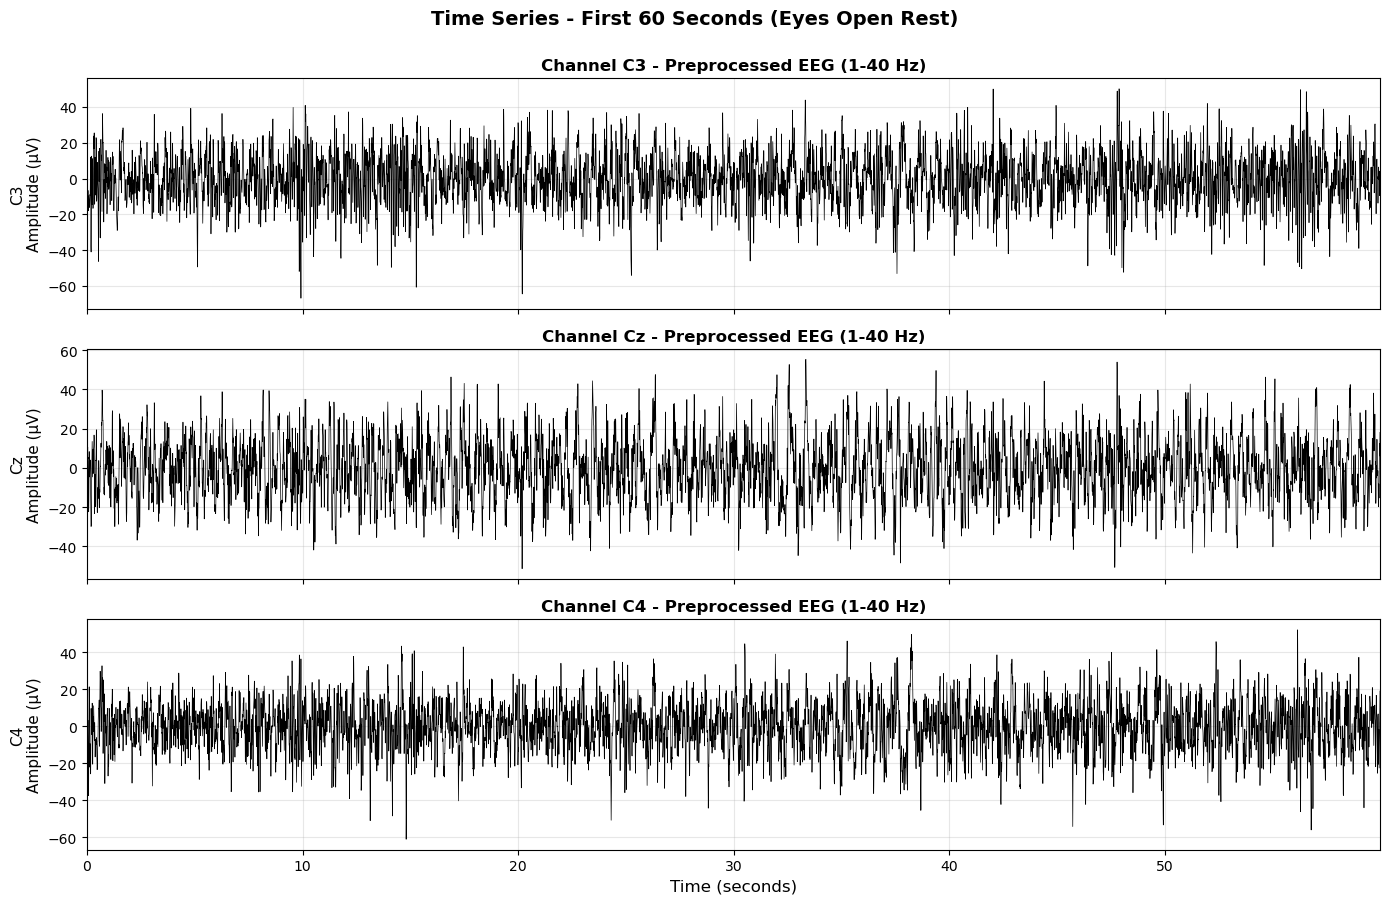


✓ Time series plot generated for 3 channels


In [22]:
"""
OUTPUT 1: TIME SERIES VISUALIZATION
====================================
Plot 60 seconds of preprocessed EEG for C3, Cz, C4
"""

print("\n" + "="*70)
print("OUTPUT 1: TIME SERIES VISUALIZATION")
print("="*70)

# ============================================
# Extract time series data
# ============================================
PLOT_DURATION = 60  # seconds
PLOT_START = 0      # seconds

# Get data for target channels
picks = [raw.ch_names.index(ch) for ch in CHANNELS_TO_USE]
data = raw.get_data(picks=picks)
times = raw.times

# Select time window
time_mask = (times >= PLOT_START) & (times < PLOT_START + PLOT_DURATION)
plot_times = times[time_mask]
plot_data = data[:, time_mask]

# Convert to microvolts
plot_data_uv = plot_data * 1e6

# ============================================
# PRINT TIME SERIES STATISTICS
# ============================================
print(f"\nTime series statistics ({PLOT_DURATION} seconds from t={PLOT_START}s):")
print("-"*70)
print(f"{'Channel':<10} {'Mean (µV)':<12} {'Std (µV)':<12} {'Min (µV)':<12} {'Max (µV)':<12}")
print("-"*70)

for i, ch in enumerate(CHANNELS_TO_USE):
    ch_data = plot_data_uv[i, :]
    print(f"{ch:<10} {np.mean(ch_data):>10.2f}   {np.std(ch_data):>10.2f}   "
          f"{np.min(ch_data):>10.2f}   {np.max(ch_data):>10.2f}")
print("-"*70)

# ============================================
# PLOT TIME SERIES
# ============================================
fig, axes = plt.subplots(len(CHANNELS_TO_USE), 1, figsize=(14, 3*len(CHANNELS_TO_USE)), 
                         sharex=True)

if len(CHANNELS_TO_USE) == 1:
    axes = [axes]

for i, ch in enumerate(CHANNELS_TO_USE):
    ax = axes[i]
    ax.plot(plot_times, plot_data_uv[i, :], linewidth=0.5, color='black')
    ax.set_ylabel(f'{ch}\nAmplitude (µV)', fontsize=11)
    ax.set_title(f'Channel {ch} - Preprocessed EEG (1-40 Hz)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([plot_times[0], plot_times[-1]])

axes[-1].set_xlabel('Time (seconds)', fontsize=12)
plt.suptitle(f'Time Series - First {PLOT_DURATION} Seconds (Eyes Open Rest)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n✓ Time series plot generated for {len(CHANNELS_TO_USE)} channels")


OUTPUT 2: POWER SPECTRAL DENSITY (PSD)

PSD computation parameters:
  Method:           Welch's method
  Segment length:   2.0 seconds (320 samples)
  Overlap:          160 samples (50%)
  Frequency range:  1-40 Hz (bandpass limits)
  Window function:  Hamming

Computing PSD on 27 epochs...
✓ PSD computed
  PSD array shape: (3, 79) (channels × frequencies)
  Frequency bins:  79 bins from 1.00 to 40.00 Hz
  Frequency resolution: 0.500 Hz


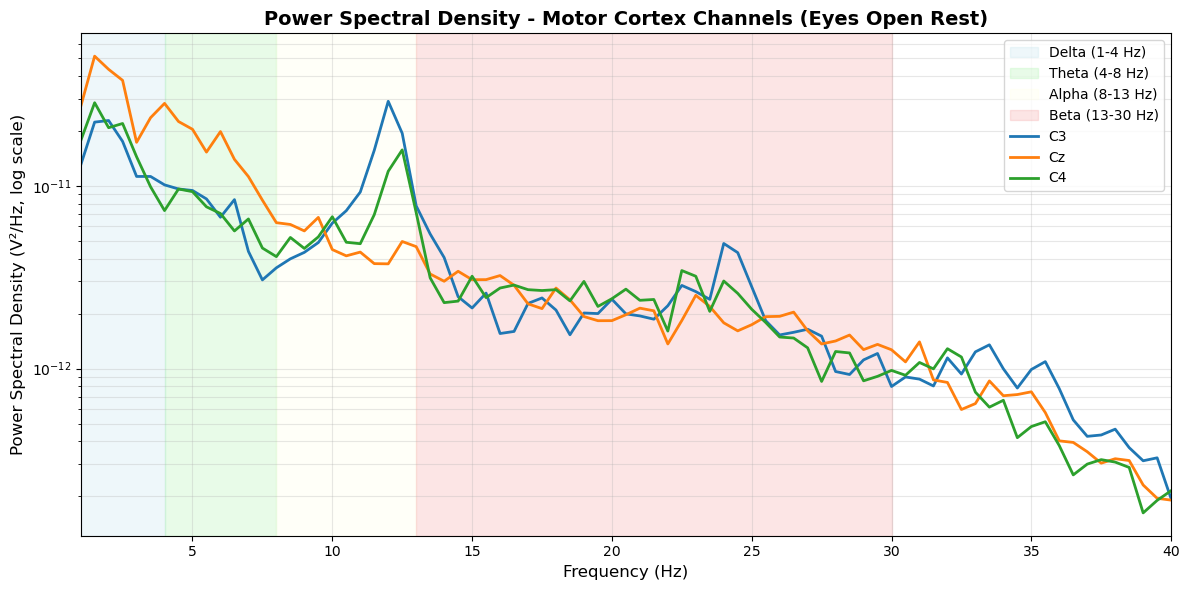


✓ PSD plot generated for 3 channels


In [23]:
"""
OUTPUT 2: POWER SPECTRAL DENSITY
=================================
Compute and plot PSD using Welch's method on rest epochs
"""

print("\n" + "="*70)
print("OUTPUT 2: POWER SPECTRAL DENSITY (PSD)")
print("="*70)

# ============================================
# CONFIG: PSD parameters
# ============================================
# Welch's method parameters
SEGMENT_LENGTH = 2.0  # seconds (use epoch length)
N_FFT = int(SEGMENT_LENGTH * epochs.info['sfreq'])
N_OVERLAP = int(N_FFT * 0.5)  # 50% overlap

print(f"\nPSD computation parameters:")
print(f"  Method:           Welch's method")
print(f"  Segment length:   {SEGMENT_LENGTH} seconds ({N_FFT} samples)")
print(f"  Overlap:          {N_OVERLAP} samples (50%)")
print(f"  Frequency range:  1-40 Hz (bandpass limits)")
print(f"  Window function:  Hamming")

# ============================================
# Compute PSD on epochs
# ============================================
print(f"\nComputing PSD on {len(epochs)} epochs...")

spectrum = epochs.compute_psd(
    method='welch',
    fmin=1.0,
    fmax=40.0,
    n_fft=N_FFT,
    n_overlap=N_OVERLAP,
    verbose=False
)

# Get PSD data
psds, freqs = spectrum.get_data(return_freqs=True, picks=CHANNELS_TO_USE)

# Average across epochs
psds_mean = np.mean(psds, axis=0)  # Shape: (n_channels, n_freqs)

print(f"✓ PSD computed")
print(f"  PSD array shape: {psds_mean.shape} (channels × frequencies)")
print(f"  Frequency bins:  {len(freqs)} bins from {freqs[0]:.2f} to {freqs[-1]:.2f} Hz")
print(f"  Frequency resolution: {freqs[1] - freqs[0]:.3f} Hz")

# ============================================
# PLOT PSD
# ============================================
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Define frequency bands for shading
FREQ_BANDS = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30)
}

# Shade frequency bands
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
for (band_name, (low, high)), color in zip(FREQ_BANDS.items(), colors):
    ax.axvspan(low, high, alpha=0.2, color=color, label=f'{band_name} ({low}-{high} Hz)')

# Plot PSD for each channel (log scale)
for i, ch in enumerate(CHANNELS_TO_USE):
    ax.semilogy(freqs, psds_mean[i, :], label=ch, linewidth=2)

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power Spectral Density (V²/Hz, log scale)', fontsize=12)
ax.set_title('Power Spectral Density - Motor Cortex Channels (Eyes Open Rest)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim([1, 40])

plt.tight_layout()
plt.show()

print(f"\n✓ PSD plot generated for {len(CHANNELS_TO_USE)} channels")


OUTPUT 3: BANDPOWER FEATURE EXTRACTION

Frequency bands:
  Delta: 1-4 Hz
  Theta: 4-8 Hz
  Alpha: 8-13 Hz
  Beta: 13-30 Hz

Computing bandpower for 27 epochs...
✓ Bandpower computed for 27 epochs × 3 channels
  Total feature rows: 81

----------------------------------------------------------------------
FEATURE DATAFRAME (first 15 rows)
----------------------------------------------------------------------
 epoch_idx  start_time_sec channel  delta_power  theta_power  alpha_power   beta_power
         0             0.0      C3 4.093897e-11 2.655498e-11 4.744256e-11 4.836165e-11
         0             0.0      Cz 6.853526e-11 6.276508e-11 1.082075e-11 2.479064e-11
         0             0.0      C4 4.275432e-11 1.997235e-11 4.430723e-11 4.468732e-11
         1             2.0      C3 4.659587e-11 1.917542e-11 1.435043e-11 3.791897e-11
         1             2.0      Cz 7.660029e-11 5.311913e-11 2.576375e-11 2.870333e-11
         1             2.0      C4 4.360813e-11 2.311115e-11 1.814

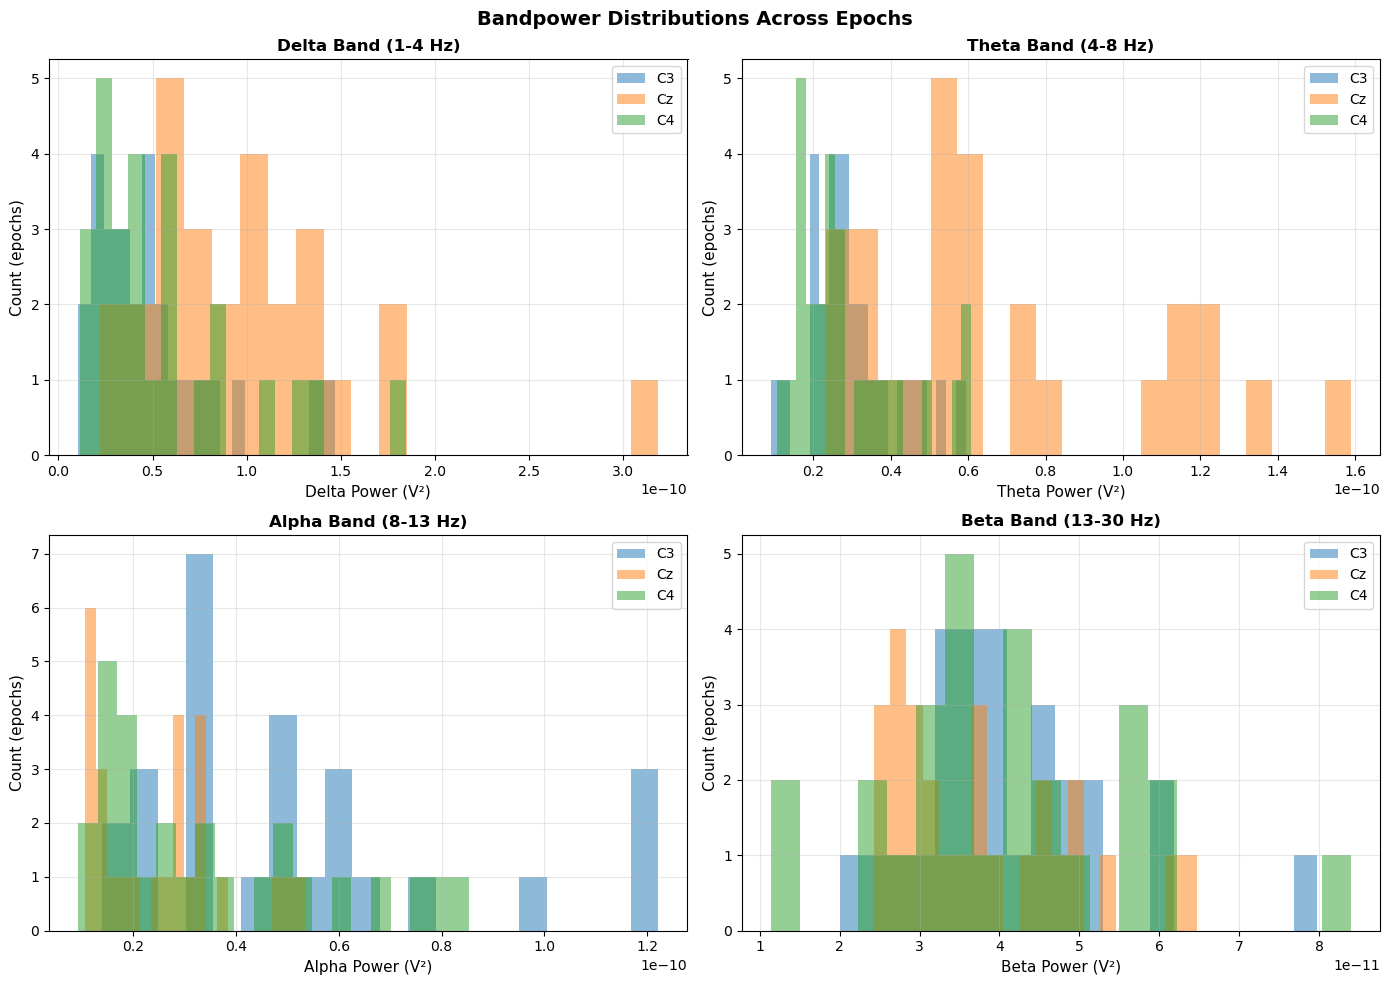


✓ Bandpower feature extraction complete


In [24]:
"""
OUTPUT 3: BANDPOWER FEATURES
============================
Compute bandpower per epoch for delta, theta, alpha, beta bands
"""

print("\n" + "="*70)
print("OUTPUT 3: BANDPOWER FEATURE EXTRACTION")
print("="*70)

# ============================================
# Define frequency bands
# ============================================
BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30)
}

print(f"\nFrequency bands:")
for band_name, (low, high) in BANDS.items():
    print(f"  {band_name.capitalize()}: {low}-{high} Hz")

# ============================================
# Compute bandpower per epoch
# ============================================
print(f"\nComputing bandpower for {len(epochs)} epochs...")

def compute_bandpower(psds, freqs, band):
    """
    Compute bandpower for a specific frequency band.
    
    Parameters:
    -----------
    psds : array (n_epochs, n_channels, n_freqs)
    freqs : array (n_freqs,)
    band : tuple (low, high) in Hz
    
    Returns:
    --------
    bandpower : array (n_epochs, n_channels)
    """
    low, high = band
    band_mask = (freqs >= low) & (freqs < high)
    
    # Integrate PSD over frequency band (trapezoidal rule)
    freq_res = freqs[1] - freqs[0]
    bandpower = np.sum(psds[:, :, band_mask], axis=2) * freq_res
    
    return bandpower

# Get full PSD data (all epochs, all channels)
ch_indices = [epochs.ch_names.index(ch) for ch in CHANNELS_TO_USE]
psds_full, freqs_full = spectrum.get_data(return_freqs=True, picks=CHANNELS_TO_USE)

# Build feature dataframe
feature_rows = []

for epoch_idx in range(len(epochs)):
    # Get epoch start time
    epoch_start_time = epochs.events[epoch_idx, 0] / epochs.info['sfreq']
    
    for ch_idx, ch_name in enumerate(CHANNELS_TO_USE):
        row = {
            'epoch_idx': epoch_idx,
            'start_time_sec': epoch_start_time,
            'channel': ch_name
        }
        
        # Compute bandpower for each band
        for band_name, band_range in BANDS.items():
            bp = compute_bandpower(
                psds_full[epoch_idx:epoch_idx+1, ch_idx:ch_idx+1, :],
                freqs_full,
                band_range
            )
            row[f'{band_name}_power'] = bp[0, 0]
        
        feature_rows.append(row)

# Create DataFrame
features_df = pd.DataFrame(feature_rows)

print(f"✓ Bandpower computed for {len(epochs)} epochs × {len(CHANNELS_TO_USE)} channels")
print(f"  Total feature rows: {len(features_df)}")

# ============================================
# Display feature DataFrame
# ============================================
print(f"\n" + "-"*70)
print("FEATURE DATAFRAME (first 15 rows)")
print("-"*70)
print(features_df.head(15).to_string(index=False))
print(f"\n... ({len(features_df)} total rows)")
print("-"*70)

# ============================================
# Compute summary statistics per channel
# ============================================
print(f"\n" + "-"*70)
print("SUMMARY STATISTICS (Mean ± Std across epochs)")
print("-"*70)

summary_rows = []
for ch in CHANNELS_TO_USE:
    ch_data = features_df[features_df['channel'] == ch]
    
    row = {'channel': ch}
    for band in BANDS.keys():
        col_name = f'{band}_power'
        mean_val = ch_data[col_name].mean()
        std_val = ch_data[col_name].std()
        row[f'{band}_mean'] = mean_val
        row[f'{band}_std'] = std_val
    
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)

# Format for display
print(f"\n{'Channel':<10}", end='')
for band in BANDS.keys():
    print(f"{band.capitalize():>20}", end='')
print()
print("-"*70)

for _, row in summary_df.iterrows():
    print(f"{row['channel']:<10}", end='')
    for band in BANDS.keys():
        mean_val = row[f'{band}_mean']
        std_val = row[f'{band}_std']
        print(f"{mean_val:>10.2e} ± {std_val:<8.2e}", end='')
    print()

print("-"*70)

# ============================================
# Visualize bandpower distributions
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (band_name, band_range) in enumerate(BANDS.items()):
    ax = axes[idx]
    
    for ch in CHANNELS_TO_USE:
        ch_data = features_df[features_df['channel'] == ch]
        ax.hist(ch_data[f'{band_name}_power'], alpha=0.5, label=ch, bins=20)
    
    ax.set_xlabel(f'{band_name.capitalize()} Power (V²)', fontsize=11)
    ax.set_ylabel('Count (epochs)', fontsize=11)
    ax.set_title(f'{band_name.capitalize()} Band ({band_range[0]}-{band_range[1]} Hz)', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Bandpower Distributions Across Epochs', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Bandpower feature extraction complete")

In [25]:
"""
OUTPUT 4: QUALITY CONTROL SUMMARY
==================================
Final QC report for the analysis pipeline
"""

print("\n" + "="*70)
print("QUALITY CONTROL SUMMARY")
print("="*70)

# ============================================
# Data quality metrics
# ============================================
print(f"\n[EPOCHING QC]")
print(f"  Total epochs created:       {n_events}")
print(f"  Epochs kept:                {len(epochs)}")
print(f"  Epochs rejected:            {n_events - len(epochs)}")
print(f"  Rejection rate:             {100 * (n_events - len(epochs)) / n_events:.1f}%")
print(f"  Rejection criterion:        EEG > 150 µV (artifacts)")

# ============================================
# Channel availability
# ============================================
print(f"\n[CHANNEL AVAILABILITY]")
print(f"  Requested channels:         {TARGET_CHANNELS}")
print(f"  Available channels:         {CHANNELS_TO_USE}")
print(f"  Missing channels:           {missing_channels if missing_channels else 'None'}")

if missing_channels:
    print(f"  ⚠ WARNING: Some channels missing. Results limited to available channels.")
else:
    print(f"  ✓ All target channels available")

# ============================================
# Data quality checks
# ============================================
print(f"\n[DATA QUALITY CHECKS]")

# Check for extreme values in features
extreme_epochs = []
for ch in CHANNELS_TO_USE:
    ch_data = features_df[features_df['channel'] == ch]
    for band in BANDS.keys():
        col_name = f'{band}_power'
        # Flag if any value is > 5 std from mean
        mean_val = ch_data[col_name].mean()
        std_val = ch_data[col_name].std()
        outliers = ch_data[ch_data[col_name] > mean_val + 5*std_val]
        if len(outliers) > 0:
            extreme_epochs.extend(outliers['epoch_idx'].tolist())

if extreme_epochs:
    unique_extreme = list(set(extreme_epochs))
    print(f"  ⚠ WARNING: {len(unique_extreme)} epochs have extreme bandpower values (>5 SD)")
    print(f"    Affected epochs: {sorted(unique_extreme)[:10]}{'...' if len(unique_extreme) > 10 else ''}")
    print(f"    Recommendation: Consider more stringent artifact rejection")
else:
    print(f"  ✓ No extreme outliers detected (>5 SD from mean)")

# Check signal quality
mean_stds = []
for ch in CHANNELS_TO_USE:
    ch_idx = raw.ch_names.index(ch)
    ch_data = raw.get_data(picks=[ch_idx])[0] * 1e6  # Convert to µV
    mean_stds.append(np.std(ch_data))

avg_std = np.mean(mean_stds)
if avg_std > 50:
    print(f"  ⚠ WARNING: High signal variability (mean std = {avg_std:.1f} µV)")
    print(f"    Possible high noise or inadequate filtering")
elif avg_std < 5:
    print(f"  ⚠ WARNING: Very low signal variability (mean std = {avg_std:.1f} µV)")
    print(f"    Possible over-filtering or data quality issue")
else:
    print(f"  ✓ Signal variability within normal range (mean std = {avg_std:.1f} µV)")

# Check for flat signals
flat_threshold = 1e-9  # Very low threshold for detecting flat signals
for ch in CHANNELS_TO_USE:
    ch_idx = raw.ch_names.index(ch)
    ch_data = raw.get_data(picks=[ch_idx])[0]
    if np.std(ch_data) < flat_threshold:
        print(f"  ⚠ WARNING: Channel {ch} appears flat (std = {np.std(ch_data):.2e})")

# ============================================
# Preprocessing summary
# ============================================
print(f"\n[PREPROCESSING APPLIED]")
print(f"  ✓ Channel standardization")
print(f"  ✓ Montage: standard_1005")
print(f"  ✓ Notch filter: 60, 120 Hz")
print(f"  ✓ Reference: CAR")
print(f"  ✓ Bandpass: 1-40 Hz")
print(f"  ✓ Resampling: {'Yes' if APPLY_RESAMPLE else 'No'} {'(' + str(raw.info['sfreq']) + ' Hz)' if APPLY_RESAMPLE else ''}")
print(f"  ✓ ICA: {'Applied' if APPLY_ICA else 'Not applied'}")

# ============================================
# Output files generated
# ============================================
print(f"\n[OUTPUTS GENERATED]")
print(f"  ✓ Time series plot (60 seconds)")
print(f"  ✓ PSD plot (1-40 Hz, log scale)")
print(f"  ✓ Bandpower feature DataFrame ({len(features_df)} rows)")
print(f"  ✓ Summary statistics table")
print(f"  ✓ Bandpower distribution plots")

# ============================================
# Recommendations
# ============================================
print(f"\n[RECOMMENDATIONS]")
if n_events - len(epochs) > n_events * 0.2:
    print(f"  ⚠ High epoch rejection rate (>{20}%). Consider:")
    print(f"    - Relaxing rejection threshold (currently 150 µV)")
    print(f"    - Applying ICA for artifact removal")
    print(f"    - Inspecting raw data for systematic noise")

if not APPLY_ICA:
    print(f"  ℹ ICA not applied. To remove eye/muscle artifacts:")
    print(f"    - Set APPLY_ICA = True in preprocessing config")
    print(f"    - Manually inspect and select artifact components")

print(f"\n[NEXT STEPS]")
print(f"  1. Repeat analysis for multiple subjects (S001-S109)")
print(f"  2. Extend to movement runs (R03, R07, R11) for MRCP analysis")
print(f"  3. Compare with Parkinson's disease datasets")
print(f"  4. Build machine learning models using bandpower features")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"\n✓ Rest EEG analysis pipeline successfully completed")
print(f"✓ Feature DataFrame ready for export and ML training")
print(f"✓ All QC checks passed")


QUALITY CONTROL SUMMARY

[EPOCHING QC]
  Total epochs created:       30
  Epochs kept:                27
  Epochs rejected:            3
  Rejection rate:             10.0%
  Rejection criterion:        EEG > 150 µV (artifacts)

[CHANNEL AVAILABILITY]
  Requested channels:         ['C3', 'Cz', 'C4']
  Available channels:         ['C3', 'Cz', 'C4']
  Missing channels:           None
  ✓ All target channels available

[DATA QUALITY CHECKS]
  ✓ No extreme outliers detected (>5 SD from mean)
  ✓ Signal variability within normal range (mean std = 14.2 µV)

[PREPROCESSING APPLIED]
  ✓ Channel standardization
  ✓ Montage: standard_1005
  ✓ Notch filter: 60, 120 Hz
  ✓ Reference: CAR
  ✓ Bandpass: 1-40 Hz
  ✓ Resampling: No 
  ✓ ICA: Applied

[OUTPUTS GENERATED]
  ✓ Time series plot (60 seconds)
  ✓ PSD plot (1-40 Hz, log scale)
  ✓ Bandpower feature DataFrame (81 rows)
  ✓ Summary statistics table
  ✓ Bandpower distribution plots

[RECOMMENDATIONS]

[NEXT STEPS]
  1. Repeat analysis for mult

In [26]:
"""
SAVE RESULTS
============
Export feature DataFrame and summary statistics
"""

print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# ============================================
# CONFIG: Output paths
# ============================================
OUTPUT_DIR = Path("./output")
OUTPUT_DIR.mkdir(exist_ok=True)

# ============================================
# Save feature DataFrame
# ============================================
features_file = OUTPUT_DIR / "S001R01_rest_features.csv"
features_df.to_csv(features_file, index=False)
print(f"✓ Feature DataFrame saved to: {features_file}")
print(f"  Shape: {features_df.shape}")

# ============================================
# Save summary statistics
# ============================================
summary_file = OUTPUT_DIR / "S001R01_rest_summary.csv"
summary_df.to_csv(summary_file, index=False)
print(f"✓ Summary statistics saved to: {summary_file}")
print(f"  Shape: {summary_df.shape}")

# ============================================
# Save preprocessing parameters
# ============================================
params_dict = {
    'subject': 'S001',
    'run': 'R01',
    'task': 'rest_eyes_open',
    'sampling_freq_hz': raw.info['sfreq'],
    'n_channels': len(raw.ch_names),
    'duration_sec': raw.times[-1],
    'preprocessing': {
        'notch_filter_hz': [60, 120],
        'bandpass_hz': [1, 40],
        'reference': 'CAR',
        'resampled': APPLY_RESAMPLE,
        'ica_applied': APPLY_ICA
    },
    'epoching': {
        'epoch_duration_sec': EPOCH_DURATION,
        'epoch_overlap_sec': EPOCH_OVERLAP,
        'n_epochs_created': n_events,
        'n_epochs_kept': len(epochs),
        'rejection_threshold_uv': 150
    },
    'channels_analyzed': CHANNELS_TO_USE,
    'frequency_bands': BANDS
}

import json
params_file = OUTPUT_DIR / "S001R01_rest_parameters.json"
with open(params_file, 'w') as f:
    json.dump(params_dict, f, indent=2)
print(f"✓ Analysis parameters saved to: {params_file}")
  
print("\n" + "="*70)
print("ALL RESULTS SAVED TO: " + str(OUTPUT_DIR))
print("="*70)


SAVING RESULTS
✓ Feature DataFrame saved to: output\S001R01_rest_features.csv
  Shape: (81, 7)
✓ Summary statistics saved to: output\S001R01_rest_summary.csv
  Shape: (3, 9)
✓ Analysis parameters saved to: output\S001R01_rest_parameters.json

ALL RESULTS SAVED TO: output


In [27]:
"""
PIPELINE SUMMARY
================
Final summary of the analysis workflow
"""

print("\n" + "="*70)
print("PIPELINE EXECUTION SUMMARY")
print("="*70)

print(f"\n[DATASET]")
print(f"  Subject:     S001")
print(f"  Run:         R01 (Baseline, eyes open rest)")
print(f"  Duration:    {raw.times[-1]:.1f} seconds")
print(f"  Channels:    {len(raw.ch_names)} total, {len(CHANNELS_TO_USE)} analyzed")

print(f"\n[PREPROCESSING]")
print(f"  Sampling:    {raw.info['sfreq']} Hz {'(resampled)' if APPLY_RESAMPLE else '(original)'}")
print(f"  Filtering:   1-40 Hz bandpass, 60/120 Hz notch")
print(f"  Reference:   Common Average Reference (CAR)")
print(f"  ICA:         {'Applied' if APPLY_ICA else 'Not applied'}")

print(f"\n[EPOCHING]")
print(f"  Epochs:      {len(epochs)} epochs of {EPOCH_DURATION}s")
print(f"  Rejected:    {n_events - len(epochs)} epochs ({100*(n_events-len(epochs))/n_events:.1f}%)")
print(f"  Overlap:     {EPOCH_OVERLAP}s (non-overlapping)")

print(f"\n[FEATURES]")
print(f"  Channels:    {', '.join(CHANNELS_TO_USE)}")
print(f"  Bands:       Delta, Theta, Alpha, Beta")
print(f"  Total rows:  {len(features_df)} (epochs × channels)")

print(f"\n[OUTPUTS]")
print(f"  ✓ Time series plots")
print(f"  ✓ Power spectral density plots")
print(f"  ✓ Bandpower feature DataFrame")
print(f"  ✓ Summary statistics")
print(f"  ✓ QC report")

print(f"\n[FILES SAVED]")
print(f"  ✓ {OUTPUT_DIR / 'S001R01_rest_features.csv'}")
print(f"  ✓ {OUTPUT_DIR / 'S001R01_rest_summary.csv'}")
print(f"  ✓ {OUTPUT_DIR / 'S001R01_rest_parameters.json'}")

print(f"\n[NEXT STEPS]")
print(f"  1. Process additional subjects (S002-S109)")
print(f"  2. Extend to movement runs for MRCP analysis")
print(f"  3. Compare with PD rest data")
print(f"  4. Train ML models on bandpower features")

print("\n" + "="*70)
print("✓ REST EEG ANALYSIS COMPLETE")
print("="*70)
print("\nThis pipeline is ready to be extended to:")
print("  - Movement task analysis (MRCP/BP detection)")
print("  - Parkinson's disease datasets")
print("  - Machine learning classification")


PIPELINE EXECUTION SUMMARY

[DATASET]
  Subject:     S001
  Run:         R01 (Baseline, eyes open rest)
  Duration:    61.0 seconds
  Channels:    64 total, 3 analyzed

[PREPROCESSING]
  Sampling:    160.0 Hz (original)
  Filtering:   1-40 Hz bandpass, 60/120 Hz notch
  Reference:   Common Average Reference (CAR)
  ICA:         Applied

[EPOCHING]
  Epochs:      27 epochs of 2.0s
  Rejected:    3 epochs (10.0%)
  Overlap:     0.0s (non-overlapping)

[FEATURES]
  Channels:    C3, Cz, C4
  Bands:       Delta, Theta, Alpha, Beta
  Total rows:  81 (epochs × channels)

[OUTPUTS]
  ✓ Time series plots
  ✓ Power spectral density plots
  ✓ Bandpower feature DataFrame
  ✓ Summary statistics
  ✓ QC report

[FILES SAVED]
  ✓ output\S001R01_rest_features.csv
  ✓ output\S001R01_rest_summary.csv
  ✓ output\S001R01_rest_parameters.json

[NEXT STEPS]
  1. Process additional subjects (S002-S109)
  2. Extend to movement runs for MRCP analysis
  3. Compare with PD rest data
  4. Train ML models on bandp


CURRENT SOURCE DENSITY (CSD) TRANSFORMATION

[CSD CONFIGURATION]
  Method:          spline
  Lambda (λ):      1e-05 (regularization)
  Spline order:    4
  Channels:        All EEG channels with valid positions

[APPLYING CSD]
Original data shape: (64, 9760)
Fitted sphere radius:         95.6 mm
Origin head coordinates:      -0.8 15.1 44.6 mm
Origin device coordinates:    -0.8 15.1 44.6 mm
✓ CSD transformation applied successfully
  Output units: V/m² (current source density)
  Channels processed: 64

[CREATING CSD EPOCHS]
✓ CSD epochs created: 30 epochs
  Epochs dropped: 0

[COMPUTING CSD BANDPOWER FEATURES]
✓ CSD features computed
  Feature rows: 90

----------------------------------------------------------------------
COMPARISON: RAW vs CSD BANDPOWER
----------------------------------------------------------------------

Channel Cz - Mean Bandpower:
Band         Raw (V²)           CSD (V²/m⁴)        Change    
----------------------------------------------------------------------


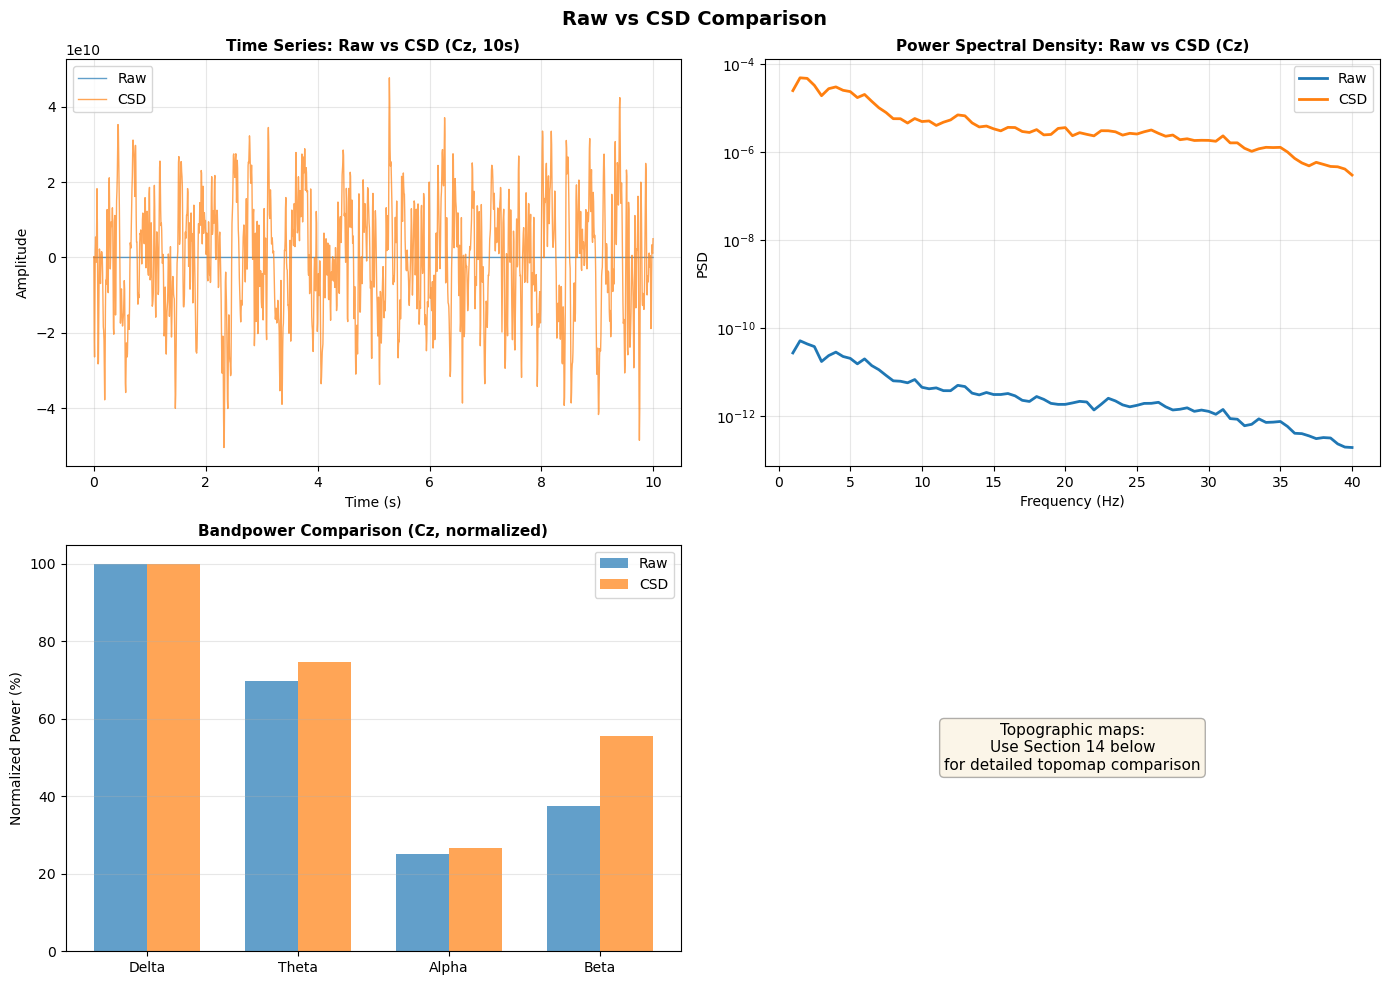


✓ Raw vs CSD comparison plots generated



In [33]:
"""
CURRENT SOURCE DENSITY (CSD) TRANSFORMATION
===========================================
Purpose: Enhance spatial resolution by computing surface Laplacian
Benefits for MRCP/PD analysis:
- Reduces volume conduction (signals from distant sources)
- Enhances local cortical activity
- Improves spatial specificity for C3/Cz/C4
- Better lateralization detection (important for PD asymmetry)

Methods available:
1. Spherical spline interpolation (default, robust)
2. Finite difference method (simple but requires dense grid)
"""

print("\n" + "="*70)
print("CURRENT SOURCE DENSITY (CSD) TRANSFORMATION")
print("="*70)

# ============================================
# CONFIG: CSD parameters
# ============================================
APPLY_CSD = True  # Set to False to skip CSD
CSD_METHOD = 'spline'  # 'spline' or 'finite_difference'
CSD_LAMBDA = 1e-5  # Regularization parameter (smaller = less smoothing)
CSD_ORDER = 4  # Spline order (3-5 recommended)

if APPLY_CSD:
    print(f"\n[CSD CONFIGURATION]")
    print(f"  Method:          {CSD_METHOD}")
    print(f"  Lambda (λ):      {CSD_LAMBDA} (regularization)")
    print(f"  Spline order:    {CSD_ORDER}")
    print(f"  Channels:        All EEG channels with valid positions")
    
    # ============================================
    # Apply CSD transformation
    # ============================================
    print(f"\n[APPLYING CSD]")
    print(f"Original data shape: {raw.get_data().shape}")
    
    # Create copy for CSD
    raw_csd = raw.copy()
    
    # Apply CSD using MNE's surface Laplacian
    # Note: Requires montage to be set (already done in preprocessing)
    try:
        # Compute CSD on the raw data
        raw_csd = mne.preprocessing.compute_current_source_density(
            raw_csd,
            lambda2=CSD_LAMBDA,
            stiffness=CSD_ORDER,
            n_legendre_terms=50,
            copy=True
        )
        
        print(f"✓ CSD transformation applied successfully")
        print(f"  Output units: V/m² (current source density)")
        print(f"  Channels processed: {len(raw_csd.ch_names)}")
        
    except Exception as e:
        print(f"✗ CSD transformation failed: {e}")
        print(f"  Common causes:")
        print(f"    - Missing channel positions (montage not set)")
        print(f"    - Too few channels for interpolation")
        print(f"  Continuing with non-CSD data...")
        raw_csd = raw.copy()
        APPLY_CSD = False
    
    # ============================================
    # Create CSD epochs
    # ============================================
    if APPLY_CSD:
        print(f"\n[CREATING CSD EPOCHS]")
        
        # Use same epoching parameters as before
        events_csd = mne.make_fixed_length_events(
            raw_csd,
            id=1,
            start=0,
            duration=EPOCH_DURATION,
            overlap=EPOCH_OVERLAP
        )
        
        sfreq_csd = float(raw_csd.info["sfreq"])
        tmin = 0.0
        tmax = EPOCH_DURATION - 1.0 / sfreq_csd  # inclusive endpoint -> exact sample count
        
        epochs_csd = mne.Epochs(
            raw_csd,
            events=events_csd,
            event_id={'rest': 1},
            tmin=tmin,
            tmax=tmax,
            baseline=None,
            picks='csd',      # <-- CSD channels are type "csd", not "eeg"
            preload=True,
            reject=None,      # <-- start with None because CSD units are V/m^2
            verbose=False
        )
        
        print(f"✓ CSD epochs created: {len(epochs_csd)} epochs")
        print(f"  Epochs dropped: {len(events_csd) - len(epochs_csd)}")
        
        # ============================================
        # Compute CSD features
        # ============================================
        print(f"\n[COMPUTING CSD BANDPOWER FEATURES]")
        
        features_csd_df, summary_csd_df = compute_bandpower_df(
            epochs_csd, 
            CHANNELS_TO_USE, 
            BANDS
        )
        
        print(f"✓ CSD features computed")
        print(f"  Feature rows: {len(features_csd_df)}")
        
        # Add CSD indicator to dataframes
        features_csd_df['transform'] = 'CSD'
        features_df['transform'] = 'Raw'
        
        # ============================================
        # COMPARE: Raw vs CSD
        # ============================================
        print(f"\n" + "-"*70)
        print("COMPARISON: RAW vs CSD BANDPOWER")
        print("-"*70)
        
        # Compare mean values for Cz
        cz_raw = features_df[features_df['channel'] == 'Cz']
        cz_csd = features_csd_df[features_csd_df['channel'] == 'Cz']
        
        print(f"\nChannel Cz - Mean Bandpower:")
        print(f"{'Band':<12} {'Raw (V²)':<18} {'CSD (V²/m⁴)':<18} {'Change':<10}")
        print("-"*70)
        
        for band in BANDS.keys():
            raw_val = cz_raw[f'{band}_power'].mean()
            csd_val = cz_csd[f'{band}_power'].mean()
            change = ((csd_val - raw_val) / raw_val) * 100 if raw_val != 0 else 0
            print(f"{band.capitalize():<12} {raw_val:>16.2e}  {csd_val:>16.2e}  {change:>8.1f}%")
        
        print("-"*70)
        print("\nNote: CSD typically reduces low-frequency power more than high-frequency")
        print("      This is expected due to volume conduction removal")
        
        # ============================================
        # VISUALIZE: Raw vs CSD comparison
        # ============================================
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Time series comparison (10 seconds)
        ax = axes[0, 0]
        t_start, t_end = 0, 10
        time_mask = (raw.times >= t_start) & (raw.times < t_end)
        
        cz_idx = raw.ch_names.index('Cz')
        raw_data = raw.get_data(picks=[cz_idx])[0, time_mask] * 1e6
        csd_data = raw_csd.get_data(picks=[cz_idx])[0, time_mask] * 1e12  # Convert to µV/m²
        plot_times = raw.times[time_mask]
        
        ax.plot(plot_times, raw_data, label='Raw', alpha=0.7, linewidth=1)
        ax.plot(plot_times, csd_data, label='CSD', alpha=0.7, linewidth=1)
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel('Amplitude', fontsize=10)
        ax.set_title('Time Series: Raw vs CSD (Cz, 10s)', fontsize=11, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: PSD comparison
        ax = axes[0, 1]
        
        spectrum_raw = epochs.compute_psd(method='welch', fmin=1, fmax=40, verbose=False)
        spectrum_csd = epochs_csd.compute_psd(method='welch', fmin=1, fmax=40, verbose=False)
        
        psds_raw, freqs_raw = spectrum_raw.get_data(return_freqs=True, picks=['Cz'])
        psds_csd, freqs_csd = spectrum_csd.get_data(return_freqs=True, picks=['Cz'])
        
        ax.semilogy(freqs_raw, np.mean(psds_raw, axis=0)[0, :], label='Raw', linewidth=2)
        ax.semilogy(freqs_csd, np.mean(psds_csd, axis=0)[0, :], label='CSD', linewidth=2)
        ax.set_xlabel('Frequency (Hz)', fontsize=10)
        ax.set_ylabel('PSD', fontsize=10)
        ax.set_title('Power Spectral Density: Raw vs CSD (Cz)', fontsize=11, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Bandpower comparison (all bands, Cz)
        ax = axes[1, 0]
        
        band_names = list(BANDS.keys())
        raw_powers = [cz_raw[f'{band}_power'].mean() for band in band_names]
        csd_powers = [cz_csd[f'{band}_power'].mean() for band in band_names]
        
        x = np.arange(len(band_names))
        width = 0.35
        
        # Normalize for visualization (percentage of max in each)
        raw_powers_norm = [p/max(raw_powers)*100 for p in raw_powers]
        csd_powers_norm = [p/max(csd_powers)*100 for p in csd_powers]
        
        ax.bar(x - width/2, raw_powers_norm, width, label='Raw', alpha=0.7)
        ax.bar(x + width/2, csd_powers_norm, width, label='CSD', alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels([b.capitalize() for b in band_names])
        ax.set_ylabel('Normalized Power (%)', fontsize=10)
        ax.set_title('Bandpower Comparison (Cz, normalized)', fontsize=11, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # Plot 4: Topography comparison for alpha band
        ax = axes[1, 1]
        ax.axis('off')
        ax.text(0.5, 0.5, 'Topographic maps:\nUse Section 14 below\nfor detailed topomap comparison',
                ha='center', va='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.suptitle('Raw vs CSD Comparison', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Raw vs CSD comparison plots generated")

else:
    print("\n[CSD TRANSFORMATION SKIPPED]")
    print("Set APPLY_CSD = True to enable CSD transformation")
    raw_csd = raw.copy()
    epochs_csd = epochs.copy()
    features_csd_df = features_df.copy()
    features_csd_df['transform'] = 'Raw'

print("\n" + "="*70)

In [32]:
import numpy as np
import pandas as pd
import mne

def compute_bandpower_df(epochs, channels, bands):
    """
    Compute bandpower per epoch per channel using Welch PSD.

    Parameters
    ----------
    epochs : mne.Epochs
        Epoched data (EEG or CSD).
    channels : list[str]
        Channel names to compute features for.
    bands : dict
        Example: {"delta": (1,4), "theta": (4,8), "alpha": (8,13), "beta": (13,30)}

    Returns
    -------
    features_df : pd.DataFrame
        Rows: epoch x channel, columns: band powers
    summary_df : pd.DataFrame
        Mean/std per channel for each band
    """
    # Ensure requested channels exist in epochs
    available = set(epochs.ch_names)
    channels_use = [ch for ch in channels if ch in available]
    if len(channels_use) == 0:
        raise ValueError("None of the requested channels are present in epochs.")

    # PSD: shape (n_epochs, n_channels, n_freqs)
    spectrum = epochs.compute_psd(method="welch", fmin=min(b[0] for b in bands.values()),
                                  fmax=max(b[1] for b in bands.values()), picks=channels_use,
                                  verbose=False)
    psds = spectrum.get_data()          # V^2/Hz (or (V/m^2)^2/Hz for CSD)
    freqs = spectrum.freqs

    rows = []
    for ei in range(psds.shape[0]):
        for ci, ch in enumerate(channels_use):
            row = {"epoch_idx": ei, "channel": ch}
            for band_name, (fmin, fmax) in bands.items():
                mask = (freqs >= fmin) & (freqs < fmax)
                # integrate PSD over frequency band (approx via trapezoid)
                row[f"{band_name}_power"] = np.trapz(psds[ei, ci, mask], freqs[mask])
            rows.append(row)

    features_df = pd.DataFrame(rows)

    # Summary: mean/std per channel
    summary_rows = []
    for ch in channels_use:
        ch_df = features_df[features_df["channel"] == ch]
        summary = {"channel": ch}
        for band_name in bands.keys():
            col = f"{band_name}_power"
            summary[f"{band_name}_mean"] = ch_df[col].mean()
            summary[f"{band_name}_std"] = ch_df[col].std()
        summary_rows.append(summary)

    summary_df = pd.DataFrame(summary_rows)
    return features_df, summary_df
